# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import homework_l7_backend as l7bk
import os
import json
from glob import glob
import sys
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
#from __future__ import absolute_import, division, print_function
#get_ipython().run_line_magic('matplotlib', 'inline')
#tf.enable_eager_execution()
#CUDA_VISIBLE_DEVICES=-1 time python mnist_mlp.py
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.set_session(tf.Session(config=config))
###################################

#tf.executing_eagerly()

# Загружаем разметку

In [3]:
label_encoder, str_labels = l7bk.make_labels([])
print(str_labels)
print(label_encoder)

['BET', 'DOL', 'ALB', 'LAG', 'SHARK', 'YFT']
{'BET': [0, 1, 0, 0, 0, 0], 'DOL': [0, 0, 1, 0, 0, 0], 'ALB': [1, 0, 0, 0, 0, 0], 'LAG': [0, 0, 0, 1, 0, 0], 'SHARK': [0, 0, 0, 0, 1, 0], 'YFT': [0, 0, 0, 0, 0, 1]}


### Визуализируем разметку

In [4]:
boxes = l7bk.load_boxes()  # разметка детекций
nofiles = l7bk.load_NoFiles()

### Распределение размеров разметки

# Экстрактор признаков

In [5]:

with tf.device('/device:GPU:0'):
    features = l7bk.get_feature_tensor()
feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


# Сетка якорей (anchor grid)

In [6]:

def nof_anchors():
    encoded = np.zeros(shape=(l7bk.FEATURE_SHAPE[0],
                              l7bk.FEATURE_SHAPE[1], 12 ), dtype=np.float32)
    label = "NoF"
    for row in range(l7bk.FEATURE_SHAPE[0]):
        for col in range(l7bk.FEATURE_SHAPE[1]):
            dx = 0 ; dy = 0
            dw = 0 ; dh = 0
            encoded[row, col] = [1.0, dx, dy, dw, dh] + label_encoder[label]
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

## Функция потерь

In [7]:
batch_loss_arr = tf.Variable(0.0)

def confidence_loss(y_true, y_pred):
    #return tf.constant(-0.0)*y_pred
    #return confidence_loss(0.5, 1)
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss
    #return  tf.cond(tf.equal(K.shape(y_true)[1], tf.constant(6)), 
    #               lambda: tf.constant(-0.0)*y_pred, 
    #               lambda: conf_loss)
    

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:5] - y_pred[..., 1:5])
    square_loss = 0.5 * K.square(y_true[..., 1:5] - y_pred[..., 1:5])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

       
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    anchors = K.shape(y_true)[1]
    #y_true = K.reshape(y_true, ( -1, 11))
    #y_pred = K.reshape(y_pred, ( -1, 11))
    #pos_mask =  y_true[...,5] == 0
    y_true_pos = tf.boolean_mask(y_true,y_true[...,0])
    y_pred_pos = tf.boolean_mask(y_pred,y_true[...,0])
    class_loss = K.categorical_crossentropy(y_true_pos[...,5:], 
                                                y_pred_pos[...,5:],
                                                from_logits=True,
                                                axis=-1)
    class_loss = K.mean(class_loss)
    #pos_class_loss = K.sum(class_loss * y_true[..., 0], axis=-1)
    pos_class_loss = K.mean(class_loss)
    # confidence loss
    conf_loss = K.mean(confidence_loss(y_true, y_pred))
    
    conf_loss = conf_loss + 0.5*pos_class_loss

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    result = total_conf_loss + 0.5 * loc_loss
    global batch_loss_arr
    batch_loss_arr = tf.cond(tf.equal(tf.rank(batch_loss_arr) ,tf.rank(result)), 
    lambda: (result +  batch_loss_arr)/2,
    lambda: result)
    return batch_loss_arr
#def debug_loss(y_true, y_pred, neg_pos_ratio=3):
#    return tf.cond(tf.equal(tf.size(y_true), tf.constant(6)), 
#                   lambda: tf.constant(0.1)*y_pred, 
#                   lambda: total_loss(y_pred, y_true, neg_pos_ratio))
def debug_loss(y_true, y_pred, neg_pos_ratio=3):
    def debug_loss2(y_true, y_pred, neg_pos_ratio=3):
        batch_size = K.shape(y_true)[0]
        #resultten = tf.zeros_like(y_pred)*y_pred
        y_pred = tf.reshape(y_pred, (batch_size, -1,12))
        y_true = K.reshape(y_true, (batch_size, -1, 12))
        #rrr = tf.constant([0,0,0])#y_true([0])
        #yy_true = y_true[0,0,...]
        print_op = tf.print("y_true: ", K.shape(y_true),"y_pred: ", K.shape(y_pred))
        #print_op = tf.print("y_true: ", y_true[2])
        #y_true = K.reshape(y_true, (batch_size, -1, 5))
        print_op = tf.print("y_true: ", K.shape(y_true),"y_pred: ", K.shape(y_pred))
        with tf.control_dependencies([print_op]):
            return tf.zeros_like(y_pred)*y_pred
    return debug_loss2(y_true, y_pred, neg_pos_ratio)

## Загрузка данных

In [8]:
def load_img(path, target_size=(l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, nofiles, batch_size=19):
    boxes = sum(boxes.values(), [])
    boxes_len = len(boxes)
    nofile_len = len(nofiles)
    #indexes = list(range(boxes_len + nofile_len))
    indexes = list(range(boxes_len))
    random.shuffle(indexes)
    labeled = False
    while True:
        random.shuffle(boxes)
        random.shuffle(nofiles)
        #for i in range((boxes_len + nofile_len)//batch_size):
        for i in range((boxes_len)//batch_size):
            X, y0, y1 = [], [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                index = indexes[j]
                if (index < boxes_len):
                    fname = boxes[index]['filename']
                    labeled = True
                else:
                    ofs = boxes_len
                    #print("ofs=",ofs)
                    fname = nofiles[ index - ofs ]
                    labeled = False
                img_shape, img = load_img(fname, target_size=(l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT))
                #Loading the file
                #img = cv2.imread(boxes[j]['filename'], cv2.IMREAD_COLOR)[...,::-1]
                #Format for the Mul:0 Tensor
                #img = cv2.resize(img,dsize=(752,468), interpolation = cv2.INTER_CUBIC)
                #Numpy array
                #np_image_data = np.asarray(img)
                # TODO: добавьте one-hot encoding в разметку для классов
                if labeled:
                    ea = l7bk.encode_anchors(boxes[index],img.shape )
                else:
                    ea = nof_anchors()
                y0.append(ea)
                X.append(img)
            yield np.array(X), np.array(y0)
            
def validation_generator(boxes, nofiles, batch_size=19):
    boxes = sum(boxes.values(), [])
    boxes_len = len(boxes)
    nofile_len = len(nofiles)
    indexes = list(range(boxes_len + nofile_len))
    random.shuffle(indexes)
    labeled = False
    while True:
        random.shuffle(boxes)
        random.shuffle(nofiles)
        for i in range((boxes_len + nofile_len)//batch_size):
            X, y0, y1 = [], [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                index = indexes[j]
                if (index < boxes_len):
                    fname = boxes[index]['filename']
                    labeled = True
                else:
                    ofs = boxes_len
                    #print("ofs=",ofs)
                    fname = nofiles[ index - ofs ]
                    labeled = False
                img_shape, img = load_img(fname, target_size=(l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT))
                #Loading the file
                #img = cv2.imread(boxes[j]['filename'], cv2.IMREAD_COLOR)[...,::-1]
                #Format for the Mul:0 Tensor
                #img = cv2.resize(img,dsize=(752,468), interpolation = cv2.INTER_CUBIC)
                #Numpy array
                #np_image_data = np.asarray(img)
                # TODO: добавьте one-hot encoding в разметку для классов
                if labeled:
                    ea = l7bk.encode_anchors(boxes[index],img.shape )
                else:
                    ea = nof_anchors()
                y0.append(ea)
                X.append(img)
            yield np.array(X), np.array(y0)

## Добавляем выход детектора

In [9]:


#share_tensor = K.repeat_elements(feature_tensor,2,1)

#output1 , output2 = tf.split(share_tensor, 2, 1)

share_tensor = feature_tensor

output1 = share_tensor

#output2 = share_tensor

#output2  = keras.layers.BatchNormalization()(output2)

output1  = keras.layers.BatchNormalization()(output1)

#feature_tensor = features.layers[-1].output

#object_tensor = features.layers[-1].output1





# TODO: добавьте выходы для классификации детекции
#output2 = keras.layers.BatchNormalization()(feature_tensor)

output1 = keras.layers.Conv2D(11,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2')(output1)

#output2 = keras.layers.Flatten()(output2)
#output2 = keras.layers.Dense(1,  # один выход
#                activation='relu',  # функция активации  
#                kernel_regularizer=keras.regularizers.l1(1e-4))(output2)
#output2 = keras.layers.BatchNormalization()(output2)
#output2 = keras.layers.Dense(6,  # один выход
#                activation='softmax',  # функция активации  
#                kernel_regularizer=keras.regularizers.l1(1e-4))(output2)

In [10]:
#output = keras.layers.Add()([output2, output1])
#model = keras.models.load_model('model3-fishes-vgg16.hdf5', 
#                                custom_objects={'total_loss': total_loss})
model = keras.models.Model(inputs=features.inputs, outputs=output1)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 468, 752, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 468, 752, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 468, 752, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 234, 376, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 234, 376, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 234, 376, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 117, 188, 128)     0         
__________

## Обучение

In [11]:
#with tf.device('/device:CPU:0'):
adam = keras.optimizers.Adam(lr=2e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              #metrics={'conf_loss': confidence_loss})
              metrics=[keras.metrics.categorical_accuracy])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
batch_size = 3
steps_per_epoch = int(0.1*sum(map(len, boxes.values()), 0) / batch_size)
print('steps_per_epoch:',steps_per_epoch)
gen = data_generator(boxes, nofiles, batch_size=batch_size)

def scheduler(epoch):
    if epoch == 0:
        K.set_value(model.optimizer.lr, 3e-4)
    elif epoch == 1:
        K.set_value(model.optimizer.lr, 1e-4)
    elif epoch == 2:
        K.set_value(model.optimizer.lr, 3e-4)
    elif epoch > 95:
        K.set_value(model.optimizer.lr, 3e-5)
    else:
        K.set_value(model.optimizer.lr, 1e-4)
    print("epoch=",epoch)
    return K.get_value(model.optimizer.lr)

change_lr = keras.callbacks.LearningRateScheduler(scheduler)

check_point = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

steps_per_epoch: 100


In [13]:
#model.fit_generator(generator=gen, 
#                    steps_per_epoch=steps_per_epoch,
#                    epochs=100,
#                    callbacks=[check_point, change_lr])
#if True:
#with tf.device('/device:GPU:0'):
model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=105,
                    callbacks=[change_lr])
print("Debuf")
#tf.InteractiveSession()
#with tf.InteractiveSession() as sess:
#    prpop = tf.print("uuuuu",copyten,output_stream=sys.stdout)
#    sess.run(prpop) #execute init_op

Instructions for updating:
Use tf.cast instead.


/home/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


epoch= 0
Epoch 1/105
100/100 [==============================] - 133s 1s/step - loss: 1.7890 - categorical_accuracy: 0.0260
epoch= 1
Epoch 2/105
100/100 [==============================] - 121s 1s/step - loss: 1.4560 - categorical_accuracy: 0.0075
epoch= 2
Epoch 3/105
100/100 [==============================] - 120s 1s/step - loss: 1.3411 - categorical_accuracy: 0.0148
epoch= 3
Epoch 4/105
100/100 [==============================] - 121s 1s/step - loss: 1.2116 - categorical_accuracy: 0.0264
epoch= 4
Epoch 5/105
100/100 [==============================] - 122s 1s/step - loss: 1.1291 - categorical_accuracy: 0.0258
epoch= 5
Epoch 6/105
100/100 [==============================] - 121s 1s/step - loss: 1.1093 - categorical_accuracy: 0.0300
epoch= 6
Epoch 7/105
100/100 [==============================] - 121s 1s/step - loss: 0.9845 - categorical_accuracy: 0.0333
epoch= 7
Epoch 8/105
100/100 [==============================] - 121s 1s/step - loss: 0.9727 - categorical_accuracy: 0.0334
epoch= 8
Epoch 9

100/100 [==============================] - 120s 1s/step - loss: 0.1295 - categorical_accuracy: 0.0680
epoch= 66
Epoch 67/105
100/100 [==============================] - 121s 1s/step - loss: 0.1384 - categorical_accuracy: 0.0687
epoch= 67
Epoch 68/105
100/100 [==============================] - 120s 1s/step - loss: 0.1387 - categorical_accuracy: 0.0667
epoch= 68
Epoch 69/105
100/100 [==============================] - 122s 1s/step - loss: 0.1385 - categorical_accuracy: 0.0641
epoch= 69
Epoch 70/105
100/100 [==============================] - 122s 1s/step - loss: 0.1503 - categorical_accuracy: 0.0667
epoch= 70
Epoch 71/105
100/100 [==============================] - 124s 1s/step - loss: 0.1297 - categorical_accuracy: 0.0647
epoch= 71
Epoch 72/105
100/100 [==============================] - 122s 1s/step - loss: 0.1079 - categorical_accuracy: 0.0687
epoch= 72
Epoch 73/105
100/100 [==============================] - 121s 1s/step - loss: 0.1160 - categorical_accuracy: 0.0754
epoch= 73
Epoch 74/105


In [27]:
if True:
    model.save('model3-fishes-vgg16.hdf5')

In [28]:
if False:
    model = keras.models.load_model('model2-fishes-vgg16.hdf5', 
                                    custom_objects={'total_loss': total_loss})

[-4.1729217  -1.4852256  -0.79183733  7.9991207  -1.0932713 ]


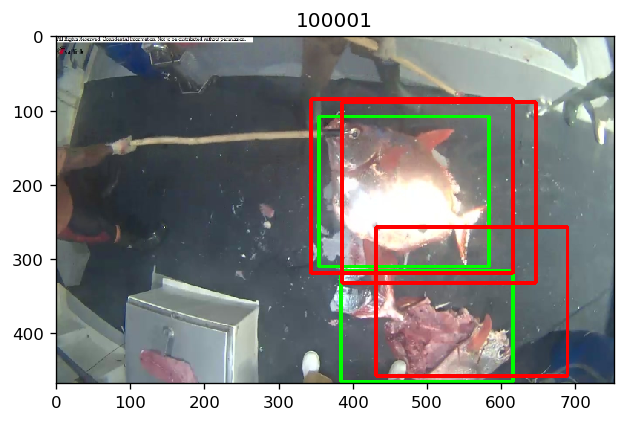

In [29]:
if True:
    example = boxes['lag'][15]

    _, sample_img = l7bk.load_img(example['filename'])
    with tf.device('/device:CPU:0'):
        pred = model.predict(np.array([sample_img,]))[0]

    decoded = l7bk.decode_prediction(pred, conf_thr=0.4)
    decoded = sorted(decoded, key=lambda e: -e['conf'])

    plt.figure(figsize=(6, 6), dpi=120)
    img = l7bk.draw_boxes(example, decoded[:3], (l7bk.IMG_WIDTH, l7bk.IMG_HEIGHT))
    plt.imshow(img)
    #plt.title('{}x{}'.format(*img.shape));
    print(decoded[0]['class'])
    plt.title("{0:b}".format(33));

## Агрегация результатов

In [30]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [31]:
def make_table():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG',
                                   'NoF', 'OTHER', 'SHARK','YFT'])
    for file in glob('./data/fish/test_stg1/*.jpg'):
        bn = os.path.basename(file)
        _, sample_img = file
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = l7bk.decode_prediction(pred, conf_thr=0.5)
        predictions = decoded['class'] + [1 - decoded['conf']]#[0, 1, 0, 1, 0, 1, 0, 1]
        pred_str = [str(ps) for ps in predictions]
        ptable.loc[len(ptable)] = [bn] + pred_str
    return ptable
if False:
    pred_table = make_table()
    print(pred_table.head())
    pred_table.to_csv("submit.csv", index=False)